Tommaso Peritore

In [92]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import statsmodels.api as sm

#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
	display: table-cell;
	text-align: center;
	vertical-align: middle;
}
</style>
""")

phase = ["Gas" , "Liquid" , "Solid"] 
data_import = ["gas_instant" , "liquid_instant" , "solid_instant"]
colors = ["steelblue" , "seagreen" , "indianred" , "mediumturquoise" , "darkseagreen" , "salmon"]
rho = [0.05 , 0.8 , 1.1]

# Exercise 7

## 7.1

In the NSL simulator code we have provided, include tail corrections for potential energy $U$, and pressure $P$.

## Solution

In the calculation for potential energy $U$ and pressure $P$ implemented in the `NSL_SIMULATOR` in the fourth exercise, a cutoff radius $r_{c}$ was chosen as the name suggests to troncate any contribution to potential and pressure from couplets of particles that were at a distance greater then that value. This is obviously an approximation, which allows to limit the interactions to be calculated but leaves out a portion of potential that could be relevant. To estimate this portion, we include now a tail correction, to compensate for the missing long-range part of the potential (and subsequently to the pressure).

It can be demonstrated that for a Lennard-Jones potential, integrating from $r=r_{cut}$ to $\infty$, the tail corrections to potential and pressure are respectively
$$
\frac{\left\langle U\right\rangle_{tail}}{N} = 8\pi\rho\varepsilon \left[\frac{1}{9 r_{c}^9} - \frac{1}{3r_{c}^3} \right]
\qquad 
\frac{\left\langle W\right\rangle_{tail}}{3N\varepsilon} = 32\pi\rho \left[\frac{1}{9 r_{c}^9} - \frac{1}{6 r_{c}^3} \right]
$$

where $r_{c}$ and $\rho$ are expressed in reduced units, and $\varepsilon = 1$ is the unit of energy. 

These corrections were implemented in the code during the initialization of properties as
````cpp
_vtail = (8/3.) * M_PI * _rho * (1/(3*pow(_r_cut,9)) - 1/pow(_r_cut,3)) ;
_ptail = (32/3.) * M_PI * _rho * (1/(3*pow(_r_cut,9)) - 1/(2*pow(_r_cut,3))) ;
`````

and once calculated, whenever the potential or pressure were estimated in the code, these tail corrections were added to the final result. 

### Comments on the code

This exercise takes off where the fourth exercise ended. We simply copied the structure of the NSL_SIMULATOR as it was in `LSN_04` and made the necessary modifications.

## 7.2

Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

## Solution

In this simulation we are in the _canonical ensemble_ which is characterized by having number of particles, volume and temperature fixed. This is because we are in the approximation of a perfect gas and the kinetic degrees of freedom are analitically integrated. Thus our evolution only focuses on the particles position, bringing modification to the configurational degrees of freedom, which we wish to simulate and evaluate. 

For this reason the values of $\rho$, $T^\star$ and $r_c$ can all be directly inserted in the input file, which I'll further comment later. This is very different from the _Molecular Dynamics_ simulation which we tackled in exercise 4, where the randomly generated positions and velocities accounted for an initial rapid variation of temperature and thus the necessity for the system to be equilibrated. Now we simply insert the values of initial temperature in the input file and it will remain constant.

For this first part of the exercise we are interested in producing instant values of _potential energy_ for a total of $M=5\times 10^5$ Monte Carlo steps. This data was produced simply by giving as input the file `./7.1/<phase>/INPUT/input_autocorrelation.in` which has `NBLOCKS`$=5\times10^5$ and `NSTEPS`$=1$ in order to exploit the average blocking already implemented but without giving as output an average calculated inside a block of a certain size. 

Furthermore, to initialize this correctly, we made it so that with `_sim_type = 1` we have in input file the first line as SIMULATION_TYPE 1 <"phase"> <"autocorrelation_bool"> <"gofr_bool">. Here of course the first bool was set to true and the second to false.

Finally, to obtain an acceptance ratio of $50\%$ we had to tweak the step size from the input files, selecting
- gas phase $\delta = 5$
- liquid phase $\delta = 0.1$
- solid phase $\delta = 0.05$

For all three phases, below we are showing all data collected as a function of the Monte Carlo steps. 

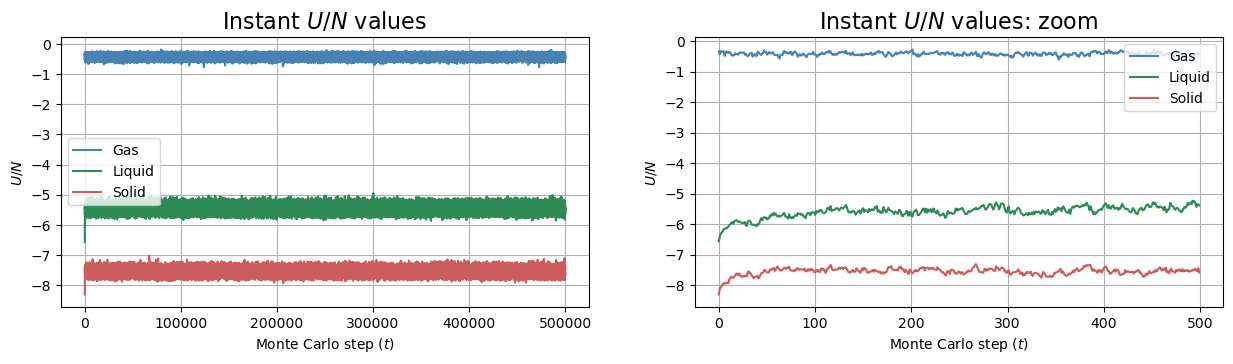

In [107]:
# instant values of potential energy

fig, axs = plt.subplots(1, 2, figsize = (15, 3.5))

for i in range(0,3) :
	data_import[i] = np.loadtxt('./7.1/'+ phase[i] + '/MC_NVT/AUTOCORRELATION/potential_energy.dat', usecols=(1))
	
	# first plot
	axs[0].plot(data_import[i], label = phase[i], color = colors[i])

	# second plot
	axs[1].plot(data_import[i][:500], label = phase[i], color = colors[i])

axs[0].set_ylabel('$U/N$')
axs[0].set_xlabel('Monte Carlo step $(t)$')
axs[0].legend()
axs[0].grid()
axs[0].set_title('Instant $U/N$ values', fontsize = 16) 

axs[1].set_ylabel('$U/N$')
axs[1].set_xlabel('Monte Carlo step $(t)$')
axs[1].legend(loc='upper right')

axs[1].set_title('Instant $U/N$ values: zoom', fontsize = 16) 
axs[1].grid()

plt.show()

### Memory and autocorrelation

In order to grasp the main reason why looking at the autocorrelation of our system is interesting, we must introduce the concept of _memory_. When talking about complex systems, with inherit complex dynamics, the property of memory refers to the ability of past events to act as an influence on future dynamics. 

Defining the _covariance_ between two random processes ($x_i$ and $x_j$) and the variance consequently as
$$
\text{cov}_{[x_i,x_j]}(t_1,t_2) \coloneqq \left\langle x_i(t_1)x_j(t_2)\right\rangle - \left\langle x_i(t_1)\right\rangle \left\langle x_j(t_2)\right\rangle 
\qquad
\text{var}_{[x]}\left(t\right) = \sigma^2_x \equiv \text{cov}_{[x,x]}(t,t) 
$$
we can then define the autocorrelation function of a stationary random process $x$ as the statistical covariance of the process with a time-delayed copy of itself. With any lag time $\tau>0$, the autocorrelation is defined as
$$ 
\text{Ac}_{[x]}(\tau) \coloneqq \frac{\text{cov}_{[x,x]}\left(t, t+\tau\right)}{\text{var}_{[x]}\left(t\right)}
$$

Thus the autocorrelation is useful to investigate the presence of memory or statistical dependence in a process. In our case, we wish to evaluate how big blocks need to de in order for them to be independent of one another.
<br> With the data collected, we plotted the autocorrelation function built in the statsmodels.api module and seeing the results we tried fitting it with an exponential law. This type of behaviour suggests that memory remains present in the system for all times, however it does give a quantity to analyze. In fact we are fitting the autocorrelation with a function like $ f(\tau) = \exp{-\tau/\tau_c} $ thus obtaining the quantity $\tau_c$ which gives an estimate for how long the process maintains a substantial memory of itself. Thus with blocks of size much bigger than $\tau_c$ one can be confident of having reduced statistical dependence.

Below we are showing the curves and their fit together with the output of the constants $\tau_c$.

tau_c Gas: 2.1358052273844037
tau_c Liquid: 9.376785742858795
tau_c Solid: 9.504299171463654


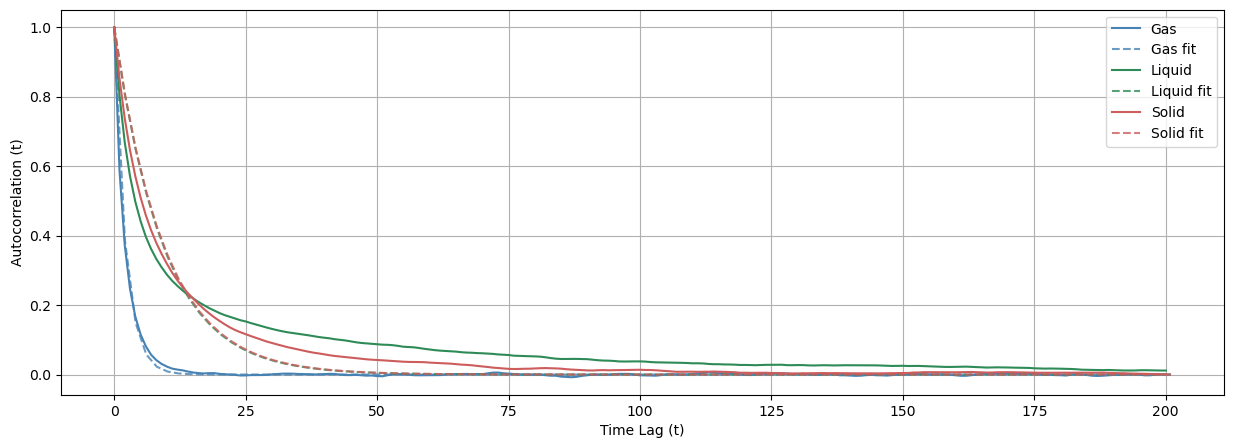

In [104]:
# autocorrelation function 

def exponential(x, a, b):
	return a * np.exp(-b * x)

def plot_autocorrelation(data, label, color):
	max_lag = 200
	
	# autocorrelation calculation
	acorr = sm.tsa.acf(data, nlags = max_lag)

	# fitting esponential function
	x = np.arange(len(acorr))
	popt, pcov = curve_fit(exponential, x, acorr, bounds = ([1, 0], [np.inf, np.inf]))
	a_fit, b_fit = popt

	# tau formula
	tau = 1 / b_fit
	print('tau_c {}: {}'.format(label, tau))

	# fit function points generaiton
	x_fit = np.linspace(0, len(acorr), 100)
	y_fit = exponential(x_fit, a_fit, b_fit)

	# plot
	plt.plot(x, acorr, label = label, c = color)
	plt.plot(x_fit, y_fit, label = label + ' fit', c = color, ls = '--', alpha = 0.8)
	

plt.figure(figsize = (15, 5))

# plot autocorrelation
for i in range (0,3) :
	plot_autocorrelation(data_import[i], phase[i], colors[i])

# plot formatting
plt.ylabel('Autocorrelation (t)')
plt.xlabel('Time Lag (t)')
plt.grid()
plt.legend()

plt.show()

From the graphs we can see how the autocorrelation drops after just a few steps.

It is interesting to note how significantly shorter of an autocorrelation the gas phase presents. This is likely due to the fact that the gas phase is much more disordered and the greater distance among particles accounts for a weaker potential interaction. 

When data close to each other (in terms of steps) are related, their statistical uncertainty can be underestimated simply because they have influenced each other. However, when we use data blocking the goal is exaclty to eliminate this influence of adjacent data by chosing a block size large enough for data within the block to ultimately result independent of each other. If that were not true, i.e. the block were too small, the progressive error we estimate would be underestimated.

To investigate how this phenomenon occurs, we are going to utilize the data already collected, and execute the block averaging with a varying block size, from $L=10$ all the way to $L=5\times 10^3$. Our data size is fixed at $M=5\times 10^5$. Here are the result of the progressive error as function of the block size.

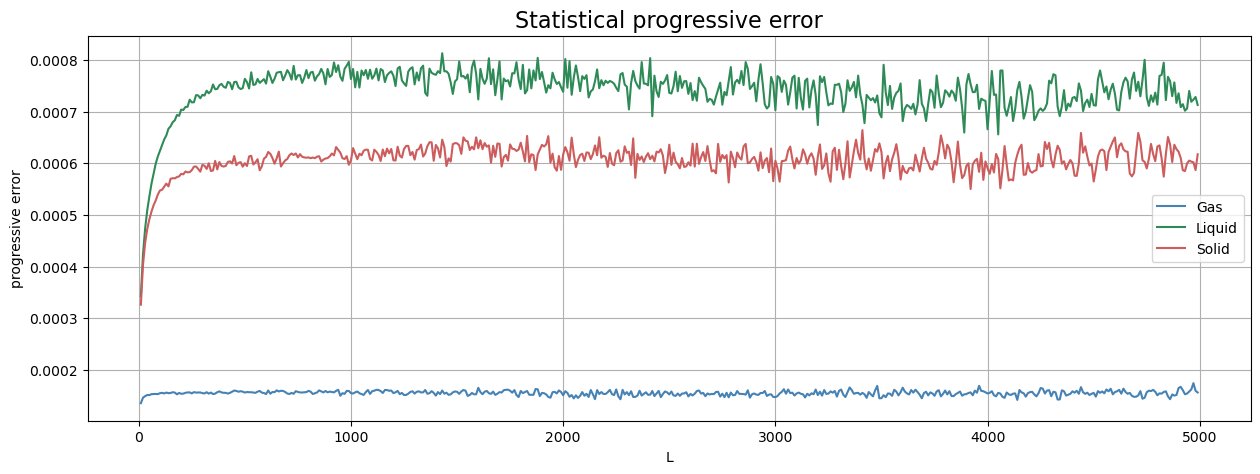

In [106]:
# statistical error calculation

def calculate_error(average, averageSquared, n): # calculate progressive error for average blocking 
	if n == 0:
		return 0	
	return np.sqrt((averageSquared - average ** 2) / n)

def data_blocking_analysis (data, blocks, blockSize): # data blocking with parameters block number and size
	progressiveAverage = 0
	progressiveAverageSquared = 0
	progressiveError = 0

	for blockIndex in range(blocks):
		blockSum = 0

		for dataIndex in range(blockSize):
			blockSum += data[dataIndex + blockIndex * blockSize]

		blockMean = blockSum / blockSize

		progressiveAverage = (progressiveAverage * blockIndex + blockMean) / (blockIndex + 1)
		progressiveAverageSquared = (progressiveAverageSquared * blockIndex + blockMean**2) / (blockIndex + 1)
		progressiveError = calculate_error(progressiveAverage, progressiveAverageSquared, blockIndex)

	return progressiveError


def plot_statistical_error(data, title, color):
	errors = []
	x_values = []
	L_range = range(L_min, L_max, 10)
	for L in L_range:
		N = int(M / L)
		err = data_blocking_analysis(data, N, L)
		errors.append(err)
		x_values.append(L)

	plt.plot(x_values, errors, label = title, color = color)


L_min = 10
L_max = 5000
M = 500000

fig = plt.figure(figsize = (15, 5))

plt.title("Statistical progressive error", fontsize = 16)

# plot statistical errors for phase
for i in range (0,3) :	
	plot_statistical_error(data_import[i], phase[i], colors[i])

# plot formatting
plt.legend()
plt.ylabel("progressive error")
plt.xlabel('L')
plt.grid(True)

plt.show()

As expected, we can clearly see how for small blocks, i.e. in the order of autocorrelation distance, the error is significantly underestimated, as it grows with bigger block sizes. We can see however that for all phases, a block size of just over $1000$ steps is already big enough for the statistical error to be estimated correctly.

## 7.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

## Solution

The radial distribution function $g(r)$ is an important probability distribution that characterizes the system in terms of atomic positioning. In fact, it gives the probability of finding a pair of atoms a distance $r$ apart from each other, relative to the probability expected for a completely random distribution at the same density. 

For a homogenous fluid like the ones we are simulating, its form is
$$
g(r) = \frac{1}{\rho N\Delta V(r)} 
		 \left\langle \sum \sum_{i\neq j=1}^N \delta(r-|\vec r_i-\vec r_j |) \right\rangle
$$
where $\Delta V(r) = \frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$ is the volume of the spherical shell of tickness $dr$ and comes from the normalization of the integral converted to discrete sum.  

To implement this algorithm, when the distance detween particles was already calculated in order to estimate the potential and pressure, we added these lines
````cpp
for (int i=0; i<_npart-1; i++){						// cycles over particles
	for (int j=i+1; j<_npart; j++){					// cycles over all other particles to make couplets
		[...] ;							// calculation of distance between particle i and particle j
		if(dr < _halfside.min() and _measure_gofr){
			_measurement(_index_gofr + int(floor(dr/double(_bin_size)))) += 2 ; 	// correct bin increased by 2 (dr(ij) and dr(ji))
		}
	}
}
````
that utilize the `_measurement` vector to keep count of where the particles distance was found. Thus when initializing the simulation, input file gives a number of bins to be used to "fill" this histogram (in our case we set `_n_bins`$=100$). 

For this simulation, input files are named in each phase subdirectory, `input_gofr.in` and as mentioned above, with `_sim_type = 1` we have SIMULATION_TYPE 1 <"phase"> <"autocorrelation_bool"> <"gofr_bool">.

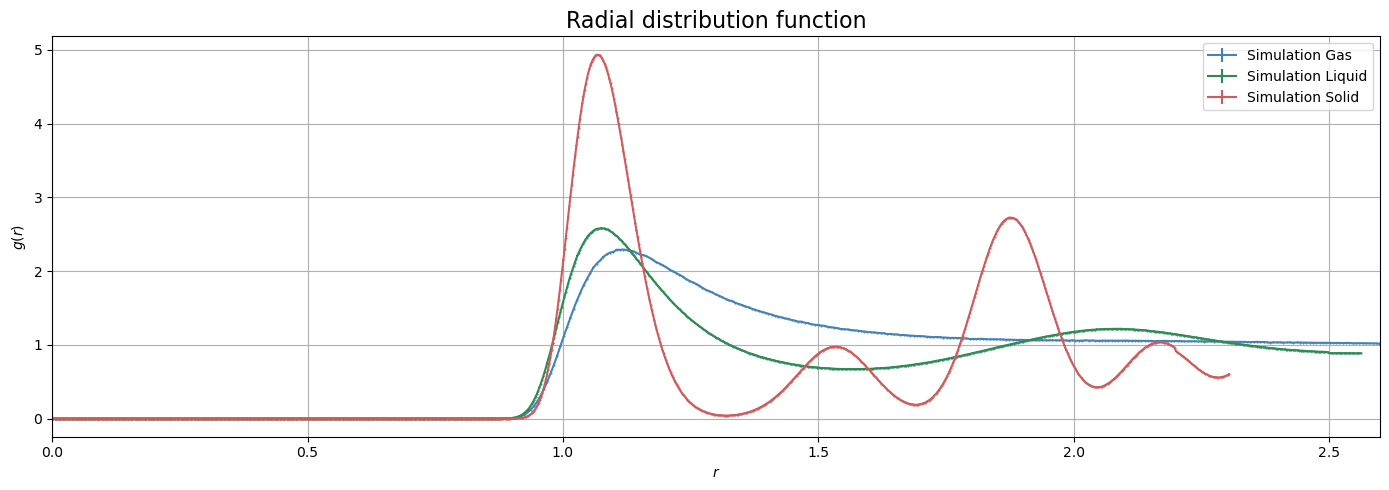

In [99]:
# radial distribution g(r)

plt.figure(figsize = (14,5))

def factor(i) :
	return ( (108/rho[i])**(1/3.) ) /2000

for i in range (0,3) :
	x_label, progressive_sum, progressive_error = np.loadtxt('./7.1/' + phase[i] + '/MC_NVT/GOFR/gofr.dat',
																				unpack = True, usecols = (0, 1, 2)) 
	plt.errorbar(x_label*factor(i), progressive_sum, yerr = progressive_error, marker = 'o', 
		markersize = 0.5, label = 'Simulation ' + phase[i], color = colors[i])

plt.title('Radial distribution function', fontsize = 16)
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.xlim(0,2.6)
plt.tight_layout()

plt.show()

### Scale factor for $r$

Let's look at how I renormalized the radius for $g(r)$ so that the distributions would be comparable.

The initialization of the radial distribution used $1000$ bins, and each bin size was set from dividing the halfside property (radius of the volume) by the number of bins.
In sequence, using $\rho$ and `_n_part` imported from input file, the volume is $V= \frac{\text{\_n\_part}}{\rho}$, side $s=V^{1/3}$ and halfside $hs=s/2$. Finally with $n=$`_n_bins`$=1000$, 

## 7.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

## Solution

input files `input_MD_NVE.in` and `input_MC_NVT.in`

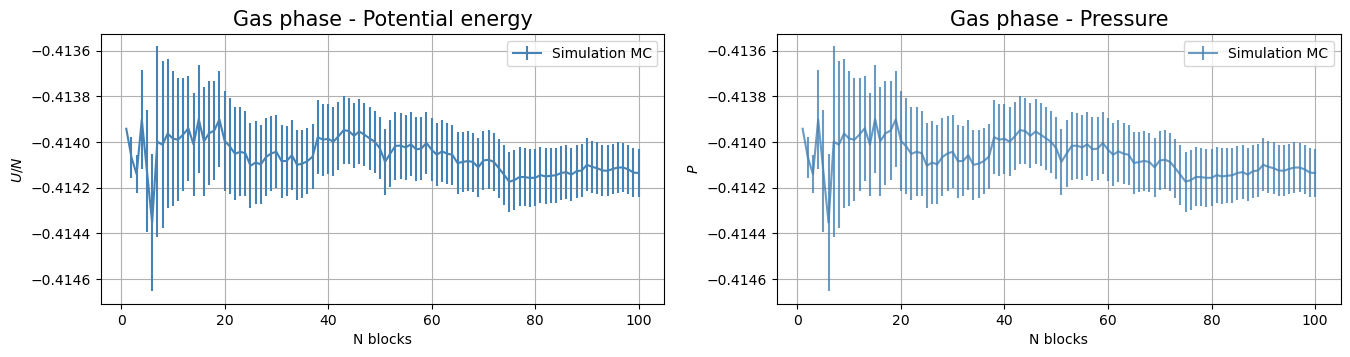

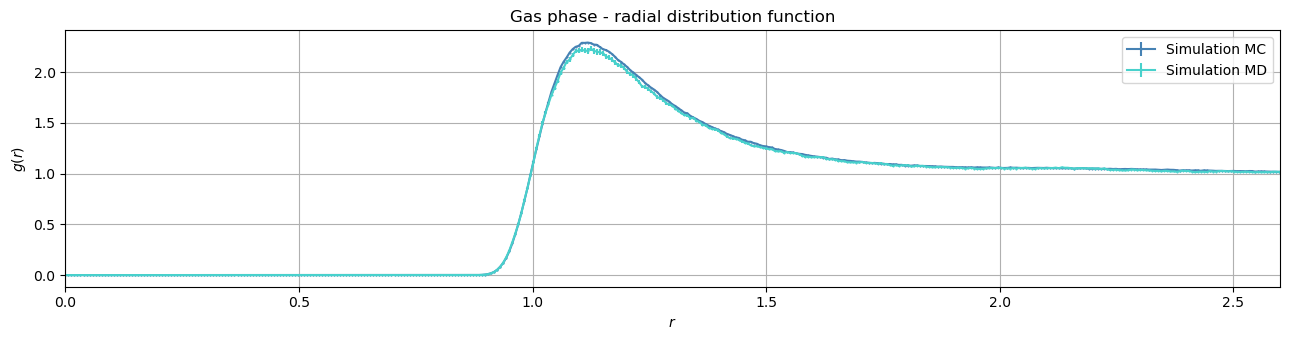

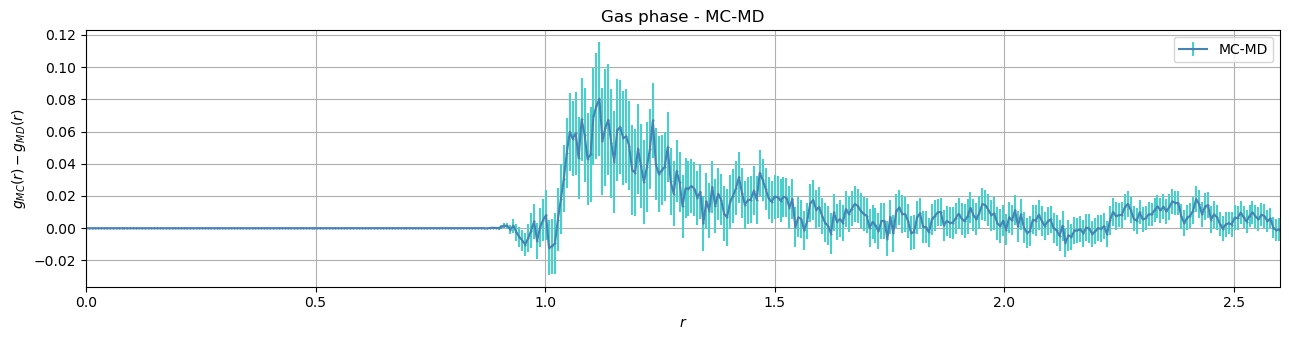

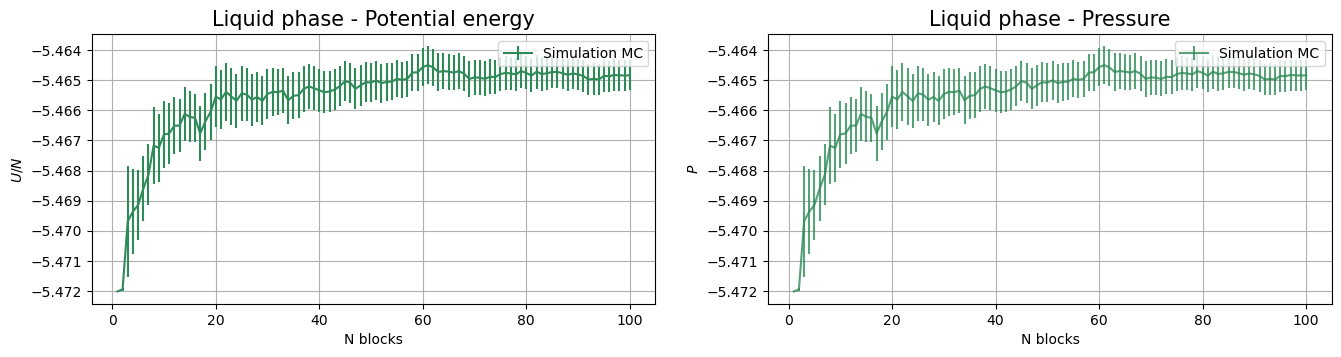

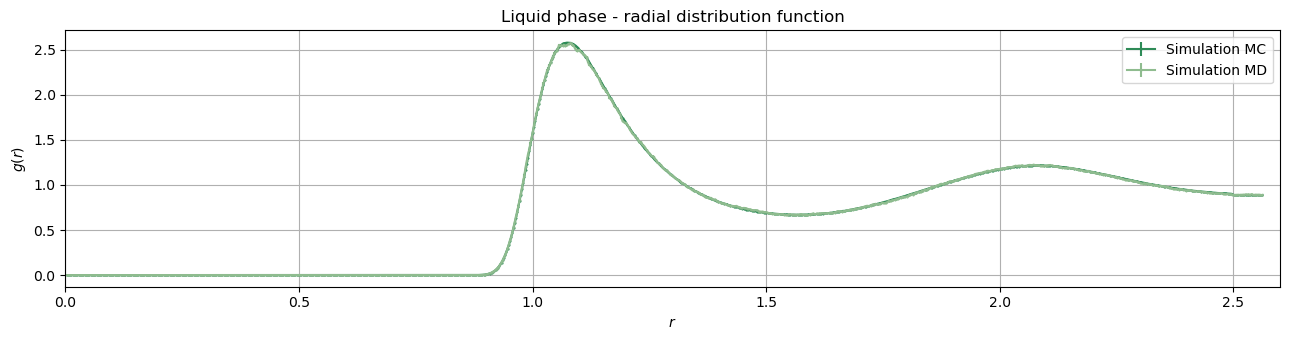

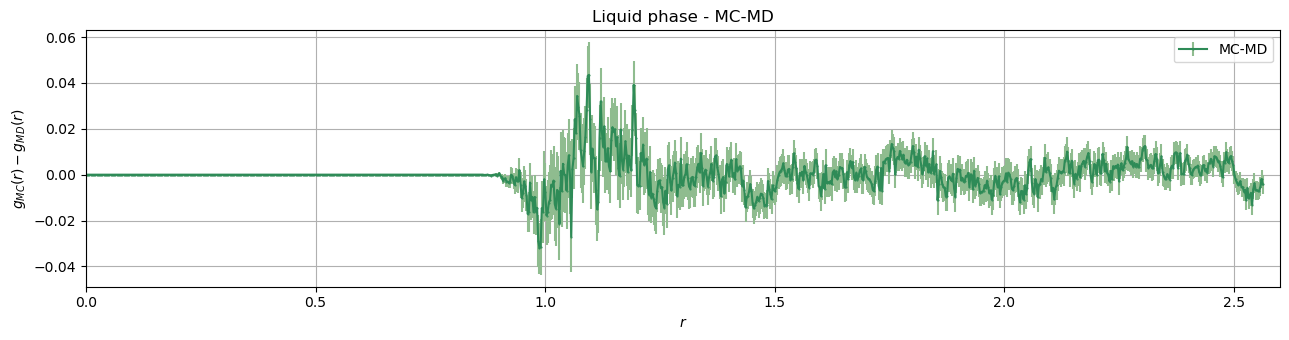

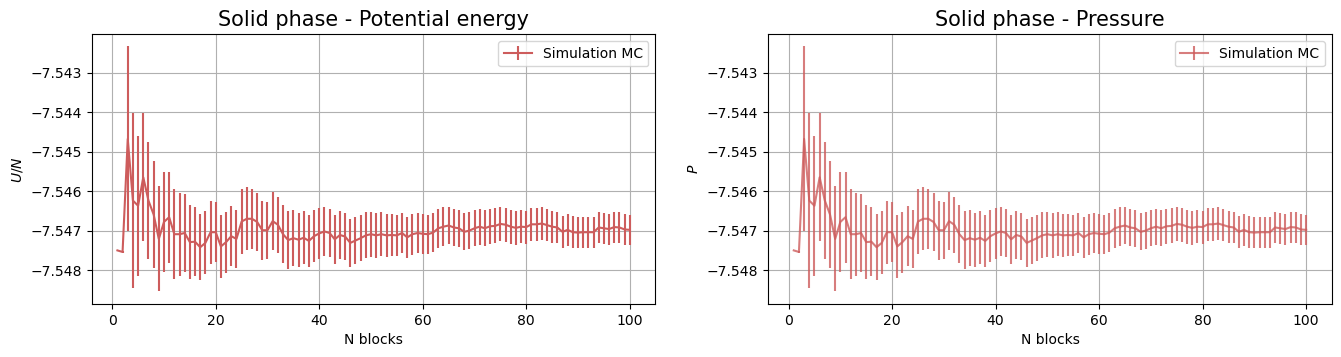

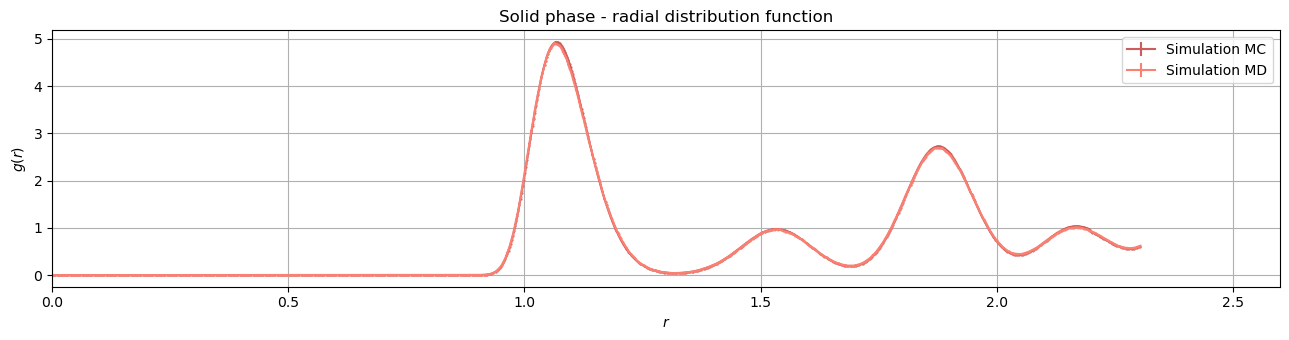

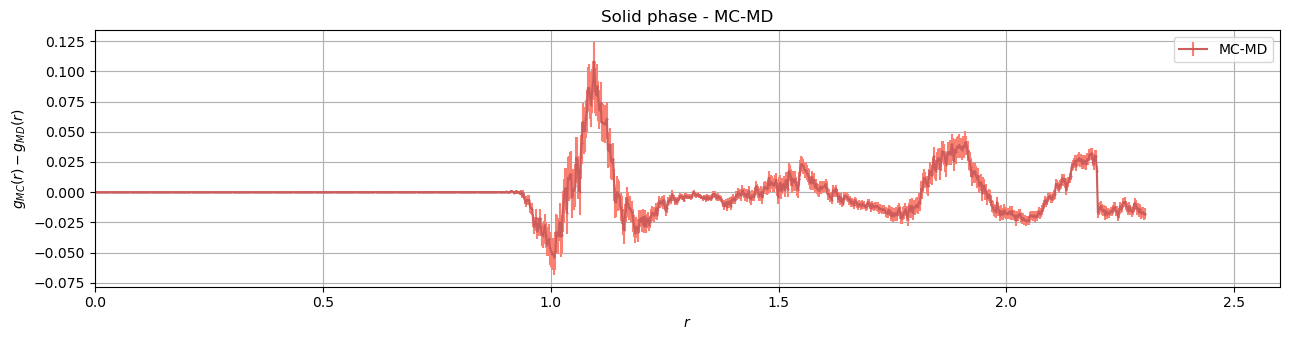

In [108]:
# simulations comparison outputs

def simulations_comparison (label, color1, color2, count) :

	fig, axs = plt.subplots(1, 2, figsize = (16, 3.5))
	
	# plot 1
	x_label, progressive_sum, progressive_error = np.loadtxt('./7.1/' + label + '/MC_NVT/OUTPUT/potential_energy.dat',
																																						 unpack = True, usecols = (0, 2, 3))
	axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
										 label = "Simulation MC", color=color1)
	axs[0].set_xlabel('N blocks')
	axs[0].set_ylabel(r'$U/N$')
	axs[0].grid(True)
	axs[0].set_title(label + ' phase - Potential energy', fontsize = 15)
	axs[0].legend()

	# plot 2
	x_label, progressive_sum, progressive_error = np.loadtxt('./7.1/' + label + '/MC_NVT/OUTPUT/potential_energy.dat',
																				unpack = True, usecols = (0, 2, 3))
	axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, 
											 label = "Simulation MC", color=color1, alpha = 0.8)
	axs[1].set_ylabel(r'$P$')
	axs[1].set_xlabel('N blocks')
	axs[1].set_title(label + ' phase - Pressure', fontsize = 15)
	axs[1].legend()
	axs[1].grid(True)
	
	plt.show()

	# MD vs MC
	plt.figure(figsize = (13,3.5))
	x_label, progressive_sum, progressive_error = np.loadtxt('./7.1/' + label + '/MC_NVT/OUTPUT/gofr.dat',
																				unpack = True, usecols = (0, 1, 2)) 
	plt.errorbar(x_label*factor(count), progressive_sum, yerr = progressive_error, marker = 'o',
									 markersize = 0.5, label = 'Simulation MC', color=color1)
	x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('./7.1/' + label + '/MD_NVE/gofr.dat',
																							unpack = True, usecols = (0, 1, 2)) 
	plt.errorbar(x_label_md*factor(count), progressive_sum_md, yerr = progressive_error_md, marker = 'o',
					markersize = 0.5, label = 'Simulation MD', color = color2)
	plt.title(label + ' phase - radial distribution function')
	plt.ylabel('$g(r)$')
	plt.xlabel('$r$')
	plt.legend()
	plt.grid()
	plt.tight_layout()
	plt.xlim(0,2.6)
	plt.show()

	# final comparison graph
	plt.figure(figsize = (13,3.5))
	plt.errorbar(x_label*factor(count), progressive_sum - progressive_sum_md, 
									 yerr = progressive_error + progressive_error_md, marker = 'o',
									 markersize = 0.5, label = 'MC-MD', color=color1, ecolor = color2)
	plt.title(label + ' phase - MC-MD')
	plt.ylabel('$g_{MC}(r)-g_{MD}(r)$')
	plt.xlabel('$r$')
	plt.legend()
	plt.grid()
	plt.xlim(0,2.6)
	plt.tight_layout()

	plt.show()

for i in range (0,3) :
	simulations_comparison(phase[i], colors[i], colors[i+3], i)
